In [18]:
## KL 11/27/2022

##~~~~~~~~~~~~~~~~~~~~~~~READ ME~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## creates spectrograms from either web (not recommended) or downloaded mp3 files (recommended)
## outputs a csv containing the merged "data.csv" and pd dataframe containing the spectrogram and spectro inputs in array format
##---- columns = y, sr, melspectro, melspectro_db, chroma_stft, Xdb

## - preprocessing notes: Video length specified is 5 seconds, all videos cut to 5 seconds (can be altered in "web_mp3_to_wav" or "pc_mp3_to_wav" functions)
##-----note: librosa.load resampling default rate is 22050 Hz, this was left default.


#---------outputs defined--------------------------------------------------------------
#y = 2D array, 1st axis = recorded samples of amplitudes in audio, 2nd axis = number of channels in audio
#sr = The sample rate:  # of samples recorded per second.

# melspectro = the default melspectrogram created from using librosa.feature.melspectrogram. Time series input y,sr provided, th emagnitued spectrogram s is computed first and mapped onto mel scale by mel_f.dot(S**power)
# melspectro_db = melspectrogram but in decibels 

#chroma_stft = returns a chromagram 
#---https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html

#Xdb = uses Short Time Fourier Transform (STFT) Method. Returns spectrogram array in Decibels. 

#----added in 'Spectrogram2.csv'

#MFCC = melspectro coefficients (better to work with for models like GMM)


In [2]:
#import libraries
import librosa 
import librosa.display
import soundfile as sf
import io
import os
from six.moves.urllib.request import urlopen
from six.moves.urllib.request import Request
import urllib.error
import numpy as np
import pandas as pd
import matplotlib as plt
import array
from pydub import AudioSegment
from pydub.utils import get_array_type
import requests
import traceback
import logging

In [3]:
#create pandas df from csv files 
df = pd.read_csv('data.csv')
display(df)

,gbifID,type,format,URL,references,license,group,Common Name,Scientific Name,Type
0,1572324720,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous
1,1572324719,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous
2,1572324718,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous
3,1572324717,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous
4,1572324716,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous
...,...,...,...,...,...,...,...,...,...,...
12370,779844324,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous
12371,779844323,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous
12372,779844321,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous
12373,779844319,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous


In [4]:
#extract URL/ID Only
df_url = df['URL']
df_id = df['gbifID']


In [5]:

def web_mp3_to_wav(url, video_length, filename):
    """
    ## takes a single web URL MP3 file path.
    opens MP3, reads using pydub/io, shortens clip to specified video_length
    ## outputs a local wav version called 'filename.wav', returns none
    """

    mp3 = urlopen(url).read()
    original=AudioSegment.from_mp3(io.BytesIO(mp3))
    section = original[:video_length*1000] #get first ten seconds (pydub operates in milliseconds)
    #url_str = url[:len(url)-4] + ".wav"
    section.export(filename, format="wav")
    #return url_str
    
def pc_mp3_to_wav(mp3, video_length, filename):
    """
    ## takes pc MP3 file path.
    opens MP3, reads using pydub/io, shortens clip to specified video_length
    ## outputs a local wav version called 'filename.wav', returns none
    """
    

    #mp3 = urlopen(url).read()
    original=AudioSegment.from_file(mp3, "mp3")
    section = original[:video_length*1000] #get first ten seconds (pydub operates in milliseconds)
    #url_str = mp3[:len(url)-4] + ".wav"
    section.export(filename, format="wav")
    #return url_str
    
def pc_mp3_to_wav_last(mp3, video_length, filename):
    """
    ## takes pc MP3 file path.
    opens MP3, reads using pydub/io, shortens clip to specified video_length
    ## outputs a local wav version called 'filename.wav', returns none
    """
    original=AudioSegment.from_file(mp3, "mp3")
    section = original[-video_length*1000:] #get last 5 sec (pydub operates in milliseconds)
    section.export(filename, format="wav")

def convert_wav_to_spectrogram(filename):
    """
    #loads and decodes audio as time series
    #(y = 1d np array, sr = sampling rate, #samples per second of audio)
    #default resample = 22050 Hz
    """
    #sfo = sf.SoundFile(filename)
    #y, sr = librosa.load(sfo)
    y, sr = librosa.load(filename)
    melspectro = librosa.feature.melspectrogram(y=y, sr=sr)
    melspectro_db = librosa.power_to_db(melspectro, ref=np.max)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return y, sr, melspectro, melspectro_db, chroma_stft, Xdb, mfcc

def remove_file(filename):
    if os.path.exists(filename):
        #filename.close()
        os.remove(filename)
    else:
        return "The file does not exist"
    

In [6]:
def create_wav_files(directory):
    id_lst = []
    # iterate over files in
    # that directory
    for filename in os.scandir(directory):
        if filename.is_file():
            id = os.path.basename(filename.path.split("-")[0])
            output =  f'{directory}/wavlast/{id}.wav'
            try: 
                pc_mp3_to_wav_last(filename.path, 5, output)
            except Exception as e:
                id_lst.append(id)
                print(e, id)

In [7]:
def output_spectrogram(directory, name):
    #---takes directory of wav files to convert and a file name (string)
    #---outputs csv files of spectrograms 
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst =[]
    melspectro_lst = []
    melspectro_db_lst = []
    chroma_stft_lst = []
    Xdb_lst = []
    mfcc_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 500 == 0:
            print(i, end=",")
        if filename.is_file():
            y, sr, melspectro, melspectro_db, chroma_stft, Xdb, mfcc = convert_wav_to_spectrogram(filename.path)
            id = os.path.basename(filename.path.split("-")[0])
            good_id_lst.append(id)
            y_lst.append(y)
            sr_lst.append(sr)
            melspectro_lst.append(melspectro)
            melspectro_db_lst.append(melspectro_db)
            chroma_stft_lst.append(chroma_stft)
            Xdb_lst.append(Xdb)
            mfcc_lst.append(mfcc)
            
    final_id_lst = []
    for i in good_id_lst:
        fin = i.split(".")[0]
        final_id_lst.append(fin)
    print("final_id_lst created")
            
    spectro_dic = {'id':final_id_lst,'y':y_lst,'sr': sr_lst,'melspectro': melspectro_lst\
            ,'melspectro_db':melspectro_db_lst,'chroma_stft':chroma_stft_lst,'Xdb':Xdb_lst, 'mfcc':mfcc_lst}
    spectro_df = pd.DataFrame(spectro_dic)

    spectro_df['gbifID'] = spectro_df['id'].astype('int64')
    spectrogram_df = pd.merge(df, spectro_df, on='gbifID', how="left")
    print("spectrogram df created")
    
    ##output to csv - rows that had errors with audio files are NaN
    name1 = name + '_nan' + '.csv'
    name2 = name + '.csv'
    spectrogram_df.to_csv(name1)
    spectrogram_df2 = spectrogram_df.dropna().reset_index(drop=True)
    spectrogram_df2.to_csv(name2)

In [12]:
def create_spectrogram(directory):
    #---takes directory of wav files to convert and a file name (string)
    #---outputs spectrogram in notebook
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst =[]
    melspectro_lst = []
    melspectro_db_lst = []
    chroma_stft_lst = []
    Xdb_lst = []
    mfcc_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 500 == 0:
            print(i, end=",")
        if filename.is_file():
            y, sr, melspectro, melspectro_db, chroma_stft, Xdb, mfcc = convert_wav_to_spectrogram(filename.path)
            id = os.path.basename(filename.path.split("-")[0])
            good_id_lst.append(id)
            y_lst.append(y)
            sr_lst.append(sr)
            melspectro_lst.append(melspectro)
            melspectro_db_lst.append(melspectro_db)
            chroma_stft_lst.append(chroma_stft)
            Xdb_lst.append(Xdb)
            mfcc_lst.append(mfcc)
    return good_id_lst, y_lst, sr_lst, melspectro_lst, melspectro_db_lst, chroma_stft_lst, Xdb_lst, mfcc_lst
    
def output_spectro_to_csv(name, good_id_lst, y_lst, sr_lst, melspectro_lst, melspectro_db_lst, chroma_stft_lst, Xdb_lst, mfcc_lst):
    #takes filename of output file in str format and lists generated from earlier function, returns nothing
    final_id_lst = []
    for i in good_id_lst:
        fin = i.split(".")[0]
        final_id_lst.append(fin)
    print("final_id_lst created")
            
    spectro_dic = {'id':final_id_lst,'y':y_lst,'sr': sr_lst,'melspectro': melspectro_lst\
            ,'melspectro_db':melspectro_db_lst,'chroma_stft':chroma_stft_lst,'Xdb':Xdb_lst, 'mfcc':mfcc_lst}
    spectro_df = pd.DataFrame(spectro_dic)

    spectro_df['gbifID'] = spectro_df['id'].astype('int64')
    spectrogram_df = pd.merge(df, spectro_df, on='gbifID', how="left")
    print("spectrogram df created")
    
    ##output to csv - rows that had errors with audio files are NaN
    name1 = name + '_nan' + '.csv'
    name2 = name + '.csv'
    spectrogram_df.to_csv(name1)
    spectrogram_df2 = spectrogram_df.dropna().reset_index(drop=True)
    spectrogram_df2.to_csv(name2)

In [13]:
## create spectrogram using last 5 seconds of the audio clips, adds MFCC
#create_wav_files(directory = '/Users/katel/Documents/output/output')
##errors out - "you should never be filling more than 2sc with silence error"

In [14]:
##used to create spectrogram2.csv - main difference is it includes mfcc column
good_id_lst, y_lst, sr_lst, melspectro_lst, melspectro_db_lst, chroma_stft_lst, Xdb_lst, mfcc_lst = create_spectrogram(directory = '/Users/katel/Documents/output/output/wavs')

C:\Users\katel\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,

In [16]:
#adds mfcc column to csv. 
output_spectro_to_csv('spectrogram2', good_id_lst, y_lst, sr_lst, melspectro_lst, melspectro_db_lst, chroma_stft_lst, Xdb_lst, mfcc_lst)

final_id_lst created
spectrogram df created


<class 'numpy.ndarray'>


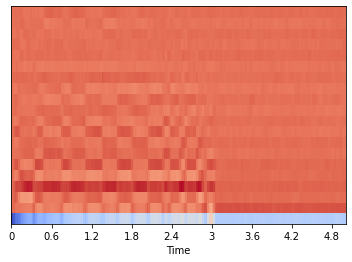

In [35]:

print(type(melspectro_db_lst[1]))
librosa.display.specshow(mfcc_lst[1], sr=sr_lst[1], x_axis='time')

## Old Code Section - used to create spectrogram.csv 

In [ ]:
#~~~~Convert local mp3 to wav (executes in ~10 min)
#-------requires downloads of files to pc, but is 1000x faster. 
#video length used is 5 seconds 
# assign directory
directory = '/Users/katel/Documents/output/output'
id_lst = []
# iterate over files in
# that directory
for filename in os.scandir(directory):
    if filename.is_file():
        id = os.path.basename(filename.path.split("-")[0])
        output =  f'{directory}/wavs/{id}.wav'
        try: 
            pc_mp3_to_wav(filename.path, 5, output)
        except Exception as e:
            id_lst.append(id)
            print(e, id)

In [59]:
#~~~~~creates spectrograms for wav files
#-----slow ~30min - 1 hr run time
# assign directory
directory = '/Users/katel/Documents/output/output/wavs'

#initialize lists
good_id_lst = []
y_lst = []
sr_lst =[]
melspectro_lst = []
melspectro_db_lst = []
chroma_stft_lst = []
Xdb_lst = []
mfcc_lst = []

# iterate over files in
# that directory
i = 0
for filename in os.scandir(directory):
    i += 1
    if i % 500 == 0:
        print(i, end=",")
    if filename.is_file():
        y, sr, melspectro, melspectro_db, chroma_stft, Xdb, mfcc = convert_wav_to_spectrogram(filename.path)
        id = os.path.basename(filename.path.split("-")[0])
        good_id_lst.append(id)
        y_lst.append(y)
        sr_lst.append(sr)
        melspectro_lst.append(melspectro)
        melspectro_db_lst.append(melspectro_db)
        chroma_stft_lst.append(chroma_stft)
        Xdb_lst.append(Xdb)
        mfcc_lst.append(mfcc)


500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,

In [60]:
#review list lengths 
print(len(good_id_lst))
print(len(y_lst))
print(len(sr_lst))
print(len(melspectro_lst))
print(len(melspectro_db_lst))
print(len(chroma_stft_lst))
print(len(Xdb_lst))

12263
12263
12263
12263
12263
12263
12263


In [66]:
final_id_lst = []
for i in good_id_lst:
    fin = i.split(".")[0]
    final_id_lst.append(fin)
    

In [80]:
spectro_dic = {'id':final_id_lst,'y':y_lst,'sr': sr_lst,'melspectro': melspectro_lst\
            ,'melspectro_db':melspectro_db_lst,'chroma_stft':chroma_stft_lst,'Xdb':Xdb_lst, 'mfcc':mfcc_lst}
spectro_df = pd.DataFrame(spectro_dic)

#final_df[final_df["url"].str.contains("http://www.tierstimmenarchiv.de/recordings/Mülleripicus_pulverulentus_Lue0074_01_short.mp3|\
                                      #http://www.tierstimmenarchiv.de/recordings/Mülleripicus_pulverulentus_Lue0074_02_short.mp3|\
                                      #http://www.tierstimmenarchiv.de/recordings/Phylloscopus_trochilus_Bru_DAT0033_02_short.mp3")==False]

display(spectro_df)
spectro_df['gbifID'] = spectro_df['id'].astype('int64')

,id,y,sr,melspectro,melspectro_db,chroma_stft,Xdb
0,1052777745,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[0.0, 4.745243e-09, 1.17788275e-07, 5.52527e-...","[[-80.0, -80.0, -80.0, -75.77498, -71.33095, -...","[[0.0, 0.53208274, 0.7386891, 0.8101316, 0.574...","[[-50.544067, -50.544067, -50.544067, -50.5440..."
1,1052777746,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[2.152914e-13, 2.0802377e-06, 4.980348e-05, 0...","[[-80.0, -71.46105, -57.669582, -47.58287, -43...","[[0.8194434, 0.9595687, 0.12185682, 0.25820193...","[[-49.06782, -49.06782, -46.78251, -30.28124, ..."
2,1052777747,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[0.0, 7.742433e-08, 3.4348543e-06, 6.233889e-...","[[-80.0, -80.0, -72.336914, -69.748405, -74.98...","[[0.0, 0.98452497, 0.5937533, 0.42880142, 0.53...","[[-51.628685, -51.628685, -39.83811, -36.93416..."
3,1052777748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[3.9051156e-06, 0.0005296526, 0.008135824, 0....","[[-69.20589, -47.882313, -36.018208, -29.95126...","[[0.5766741, 0.52541673, 0.9193191, 0.8158109,...","[[-42.651443, -34.72705, -18.373323, -9.9667, ..."
4,1052777749,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[3.5830594e-10, 1.9336358e-06, 5.87491e-05, 0...","[[-80.0, -60.15589, -45.329628, -42.82044, -44...","[[0.8566686, 0.73106414, 0.83568436, 0.7019474...","[[-64.206, -56.64289, -47.241653, -51.99855, -..."
...,...,...,...,...,...,...,...
12258,991952362,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[3.1157856e-07, 1.052358e-05, 6.911941e-05, 0...","[[-80.0, -71.14654, -62.972176, -53.946823, -5...","[[0.85438955, 0.6238523, 0.25307745, 0.1076965...","[[-44.551254, -44.551254, -40.923897, -42.0574..."
12259,991952365,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[6.3825006e-05, 0.0027457245, 0.071227655, 0....","[[-67.88009, -51.543427, -37.403507, -34.86626...","[[0.5946318, 0.64023775, 0.59130716, 0.4247977...","[[-33.71457, -29.193943, -28.461838, -39.13756..."
12260,991953213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[8.364961e-06, 0.10857487, 0.79955816, 1.5880...","[[-80.0, -45.918133, -37.246925, -34.266914, -...","[[0.57535, 0.7093672, 0.7774989, 0.7636234, 0....","[[-31.014893, 0.7429334, -10.108028, 3.0771837..."
12261,991953214,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[[6.3114175e-07, 2.4010225e-05, 0.00052887376,...","[[-80.0, -68.84473, -55.41517, -49.954933, -51...","[[0.92649436, 0.9202499, 0.87493, 0.7984475, 0...","[[-44.897644, -39.760574, -44.897644, -38.2181..."


In [81]:
print(spectro_df.dtypes)
spectrogram_df = pd.merge(df, spectro_df, on='gbifID', how="left")
display(spectrogram_df)

id               object
y                object
sr                int64
melspectro       object
melspectro_db    object
chroma_stft      object
Xdb              object
gbifID            int64
dtype: object


,gbifID,type,format,URL,references,license,group,Common Name,Scientific Name,Type,id,y,sr,melspectro,melspectro_db,chroma_stft,Xdb
0,1572324720,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous,1572324720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050.0,"[[0.00020839334, 0.009247923, 0.037993155, 0.3...","[[-58.00468, -41.533077, -35.396465, -26.31083...","[[0.33644855, 0.45987204, 0.49630252, 0.651407...","[[-27.114927, -19.522707, -11.617491, -10.9736..."
1,1572324719,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous,1572324719,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050.0,"[[8.725811e-07, 0.00014373248, 0.0035910653, 0...","[[-80.0, -62.721558, -48.744877, -43.306038, -...","[[0.37955865, 0.23792116, 0.26508343, 0.397028...","[[-44.178226, -29.47525, -23.275486, -8.331509..."
2,1572324718,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous,1572324718,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050.0,"[[1.29440195e-05, 0.0067275935, 0.051119044, 0...","[[-65.49129, -38.33338, -29.52615, -21.865246,...","[[0.60654145, 0.6226416, 0.8243289, 0.96637934...","[[-37.32677, -29.742996, -11.079779, -14.90891..."
3,1572324717,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous,1572324717,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050.0,"[[2.8849288e-06, 0.0025571426, 0.016399221, 0....","[[-75.18198, -45.705772, -37.635094, -22.72946...","[[0.8089813, 0.81026065, 0.9336924, 0.42671964...","[[-40.872856, -11.780343, -6.367126, -3.271641..."
4,1572324716,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cre...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Aves,Corn Crake,Crex crex,Not Dangerous,1572324716,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050.0,"[[6.142238e-05, 0.0061354307, 0.06469879, 0.28...","[[-60.861855, -40.86667, -30.63616, -24.15398,...","[[0.945572, 0.72711, 0.6229705, 0.63063526, 0....","[[-31.734558, -24.564798, -22.052708, -10.8359..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12370,779844324,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12371,779844323,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12372,779844321,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12373,779844319,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Aci...,http://www.tierstimmenarchiv.de/webinterface/c...,http://creativecommons.org/licenses/by-nc-sa/4.0/,Carnivora,Cheetah,Acinonyx jubatus,Dangerous,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
print(len(spectrogram_df))
print(spectrogram_df['y'].isna().sum())
print(len(spectro_df))

12375
112
12263


In [90]:
##output to csv - rows that had errors with audio files are NaN
spectrogram_df.to_csv('spectrograms_nan.csv')

In [91]:
#output to csv no missing values (rows that couldn't convert removed)
spectrogram_df2 = spectrogram_df.dropna().reset_index(drop=True)
spectrogram_df2.to_csv('spectrograms.csv')

In [92]:
print(len(spectrogram_df2))

12262


In [6]:
### - works by converting directly from web to wav, extremely slow - do not use.
%%time
"""
#initialize params
video_length = 5 #specify video size (seconds)
filename = 'test.wav'

#initialize lists
bad_url_lst = []
url_lst = []
y_lst = []
sr_lst =[]
melspectro_lst = []
melspectro_db_lst = []
chroma_stft_lst = []
Xdb_lst = []

#loop through url list
i=0
#for url in df_url[:5]:
for url in df_url:
    i+=1
    if i%1000 == 0:
        print(i)
    try:
        web_mp3_to_wav(url, video_length, filename)
    except urllib.error.URLError or urllib.error.HTTPError:
        print("remove this:", url)
        bad_url_lst.append(url)
        url_lst.append("error")
        y_lst.append("error")
        sr_lst.append("error")
        melspectro_lst.append("error")
        melspectro_db_lst.append("error")
        chroma_stft_lst.append("error")
        Xdb_lst.append("error")
    except Exception as e:
        print("remove this:", url)
        bad_url_lst.append(url)
        url_lst.append("error")
        y_lst.append("error")
        sr_lst.append("error")
        melspectro_lst.append("error")
        melspectro_db_lst.append("error")
        chroma_stft_lst.append("error")
        Xdb_lst.append("error")
        logging.error(traceback.format_exc())
    else:
        # Process data from URL if it works
        # If an exception caught you won't 
        # enter in this else block
        y, sr, melspectro, melspectro_db, chroma_stft, Xdb = convert_wav_to_spectrogram(filename)
    
        url_lst.append(url)
        y_lst.append(y)
        sr_lst.append(sr)
        melspectro_lst.append(melspectro)
        melspectro_db_lst.append(melspectro_db)
        chroma_stft_lst.append(chroma_stft)
        Xdb_lst.append(Xdb)
        #remove_file(filename)
    
print('Loop finished')
"""

ERROR:root:Traceback (most recent call last):
  File "<timed exec>", line 22, in <module>
  File "<ipython-input-5-ae624e84a1d2>", line 8, in web_mp3_to_wav
    mp3 = urlopen(url).read()
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 542, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 502, in _call_chain
    result = func(*args)
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 1379, in http_open
    return self.do_open(http.client.HTTPConnection, req)
  File "C:\Users\katel\anaconda3\lib\urllib\request.py", line 1350, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "C:\Users\katel\anaconda3\lib\http\clie

remove this: http://www.tierstimmenarchiv.de/recordings/Mülleripicus_pulverulentus_Lue0074_01_short.mp3
remove this: http://www.tierstimmenarchiv.de/recordings/Mülleripicus_pulverulentus_Lue0074_02_short.mp3


C:\Users\katel\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


remove this: http://www.tierstimmenarchiv.de/recordings/Phylloscopus_trochilus_Bru_DAT0033_02_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Upupa_epops_Lue0070_04_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Upupa_epops_Lue0070_07_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Upupa_epops_Lue0070_03_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Tockus_nasutus_Lue0070_03_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Tockus_deckeni_Lue0070_02_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Tockus_nasutus_Lue0070_04_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Tockus_nasutus_Lue0070_05_short.mp3
Something bad happened
remove this: http://www.tierstimmenarchiv.de/recordings/Tockus_alboterminatus

KeyboardInterrupt: 

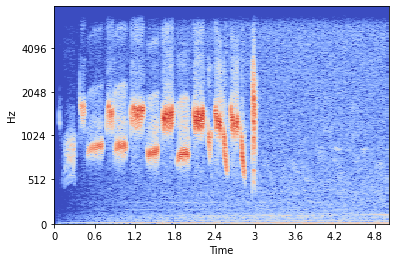

In [37]:
#view spectrograms example
img = librosa.display.specshow(Xdb_lst[1], x_axis='time', y_axis='mel', sr=sr_lst[1], fmax=8000)